In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# GPU check
!nvidia-smi -L

GPU 0: NVIDIA A100-PCIE-40GB (UUID: GPU-3fac7503-bb55-35cd-f566-c919eaa55798)
GPU 1: NVIDIA A100-PCIE-40GB (UUID: GPU-bf03abcd-ef36-6733-da57-460c8eb9cab4)
GPU 2: NVIDIA A100-PCIE-40GB (UUID: GPU-bc01f8f3-0939-f2c0-6998-dd49d0360463)
GPU 3: NVIDIA A100-PCIE-40GB (UUID: GPU-b7aeac00-b332-1045-eebc-bb5653ac8402)


In [3]:
# This is necessary only when running the notebook in the docker container
%cd fourier_learning_ibm/

/root/workdir/fourier_learning_ibm


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
from pycaret.regression import RegressionExperiment
import pickle
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from pycaret.regression import RegressionExperiment
import japanize_matplotlib

from post_process import (
    extract_probs,
)

In [5]:
import warnings

warnings.filterwarnings("ignore")

In [6]:
n_qubits = 40
n_samples = 55
backend_qpu_name = "ibm_marrakesh"

path_exact = f"results/fourier_feature_exact/{n_qubits}Q"
path_sim_noiseless = f"results/fourier_feature_sim_noiseless/{n_qubits}Q"
path_sim_noisy = f"results/fourier_feature_sim_noisy/{n_qubits}Q"
path_qpu = f"results/fourier_feature_qpu/{n_qubits}Q"

## Plot probability

In [7]:
# Load the data as a json file
with open(f"{path_exact}/probs_phase0.json", "r") as f:
    probs_phase0_exact = json.load(f)
with open(f"{path_exact}/probs_phase1.json", "r") as f:
    probs_phase1_exact = json.load(f)
with open(f"{path_exact}/probs_phase2.json", "r") as f:
    probs_phase2_exact = json.load(f)
with open(f"{path_exact}/probs_phase3.json", "r") as f:
    probs_phase3_exact = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'results/fourier_feature_exact/40Q/probs_phase0.json'

In [8]:
with open(f"{path_sim_noiseless}/probs_phase0.json", "r") as f:
    probs_phase0_sim_noiseless = json.load(f)
with open(f"{path_sim_noiseless}/probs_phase1.json", "r") as f:
    probs_phase1_sim_noiseless = json.load(f)
with open(f"{path_sim_noiseless}/probs_phase2.json", "r") as f:
    probs_phase2_sim_noiseless = json.load(f)
with open(f"{path_sim_noiseless}/probs_phase3.json", "r") as f:
    probs_phase3_sim_noiseless = json.load(f)

In [9]:
with open(f"{path_sim_noisy}/probs_phase0.json", "r") as f:
    probs_phase0_sim_noisy = json.load(f)
with open(f"{path_sim_noisy}/probs_phase1.json", "r") as f:
    probs_phase1_sim_noisy = json.load(f)
with open(f"{path_sim_noisy}/probs_phase2.json", "r") as f:
    probs_phase2_sim_noisy = json.load(f)
with open(f"{path_sim_noisy}/probs_phase3.json", "r") as f:
    probs_phase3_sim_noisy = json.load(f)

In [10]:
with open(f"{path_qpu}/probs_phase0.json", "r") as f:
    probs_phase0_qpu = json.load(f)
with open(f"{path_qpu}/probs_phase1.json", "r") as f:
    probs_phase1_qpu = json.load(f)
with open(f"{path_qpu}/probs_phase2.json", "r") as f:
    probs_phase2_qpu = json.load(f)
with open(f"{path_qpu}/probs_phase3.json", "r") as f:
    probs_phase3_qpu = json.load(f)

In [11]:
# Dummy data
# probs_phase0_qpu = probs_phase0_exact
# probs_phase1_qpu = probs_phase1_exact
# probs_phase2_qpu = probs_phase2_exact
# probs_phase3_qpu = probs_phase3_exact

In [12]:
probs_phase0_exact = extract_probs(probs_phase0_exact, probs_phase0_qpu)
probs_phase1_exact = extract_probs(probs_phase1_exact, probs_phase1_qpu)
probs_phase2_exact = extract_probs(probs_phase2_exact, probs_phase2_qpu)
probs_phase3_exact = extract_probs(probs_phase3_exact, probs_phase3_qpu)

probs_phase0_sim_noiseless = extract_probs(probs_phase0_sim_noiseless, probs_phase0_qpu)
probs_phase1_sim_noiseless = extract_probs(probs_phase1_sim_noiseless, probs_phase1_qpu)
probs_phase2_sim_noiseless = extract_probs(probs_phase2_sim_noiseless, probs_phase2_qpu)
probs_phase3_sim_noiseless = extract_probs(probs_phase3_sim_noiseless, probs_phase3_qpu)

probs_phase0_sim_noisy = extract_probs(probs_phase0_sim_noisy, probs_phase0_qpu)
probs_phase1_sim_noisy = extract_probs(probs_phase1_sim_noisy, probs_phase1_qpu)
probs_phase2_sim_noisy = extract_probs(probs_phase2_sim_noisy, probs_phase2_qpu)
probs_phase3_sim_noisy = extract_probs(probs_phase3_sim_noisy, probs_phase3_qpu)

probs_phase0_qpu = extract_probs(probs_phase0_qpu, probs_phase0_qpu)
probs_phase1_qpu = extract_probs(probs_phase1_qpu, probs_phase1_qpu)
probs_phase2_qpu = extract_probs(probs_phase2_qpu, probs_phase2_qpu)
probs_phase3_qpu = extract_probs(probs_phase3_qpu, probs_phase3_qpu)

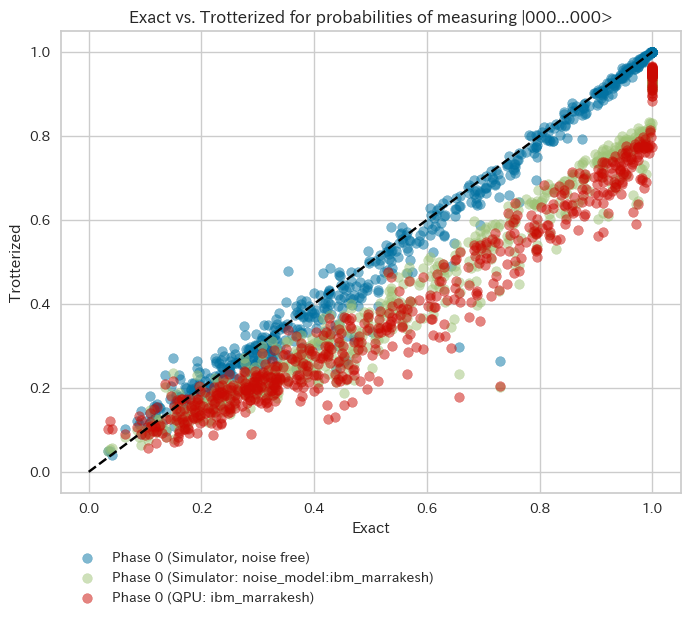

In [13]:
# Plot exact vs. Trotterized results
plt.figure(figsize=(8, 6))
plt.scatter(
    probs_phase0_exact,
    probs_phase0_sim_noiseless,
    label=f"Phase 0 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase0_exact,
    probs_phase0_sim_noisy,
    label=f"Phase 0 (Simulator: noise_model:{backend_qpu_name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase0_exact,
    probs_phase0_qpu,
    label=f"Phase 0 (QPU: {backend_qpu_name})",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

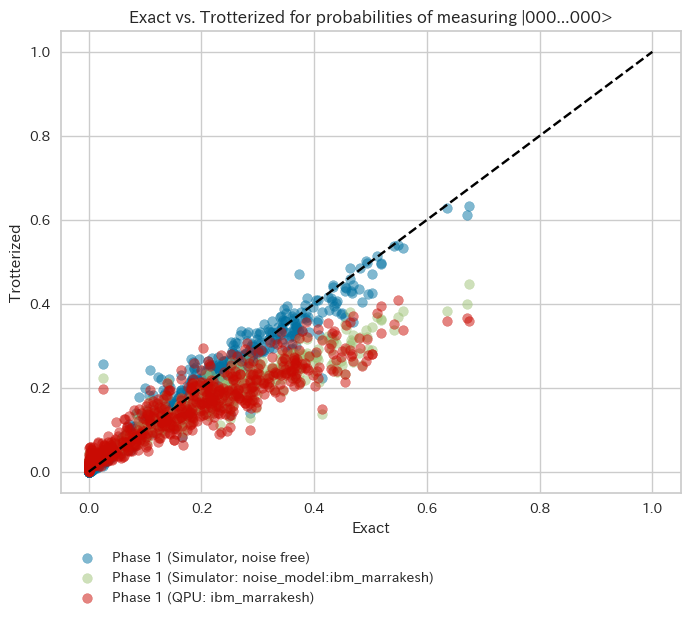

In [14]:
# Plot exact vs. Trotterized results
plt.figure(figsize=(8, 6))
plt.scatter(
    probs_phase1_exact,
    probs_phase1_sim_noiseless,
    label=f"Phase 1 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase1_exact,
    probs_phase1_sim_noisy,
    label=f"Phase 1 (Simulator: noise_model:{backend_qpu_name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase1_exact,
    probs_phase1_qpu,
    label=f"Phase 1 (QPU: {backend_qpu_name})",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

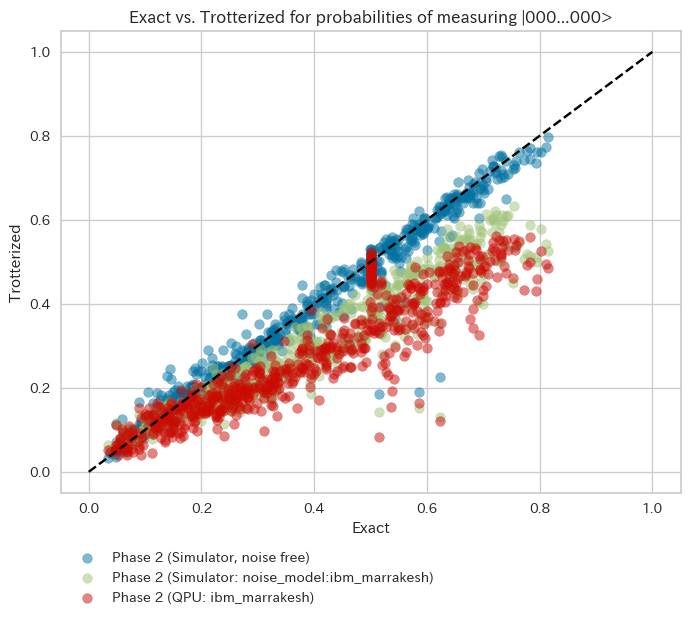

In [15]:
# Plot exact vs. Trotterized results
plt.figure(figsize=(8, 6))
plt.scatter(
    probs_phase2_exact,
    probs_phase2_sim_noiseless,
    label=f"Phase 2 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase2_exact,
    probs_phase2_sim_noisy,
    label=f"Phase 2 (Simulator: noise_model:{backend_qpu_name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase2_exact,
    probs_phase2_qpu,
    label=f"Phase 2 (QPU: {backend_qpu_name})",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

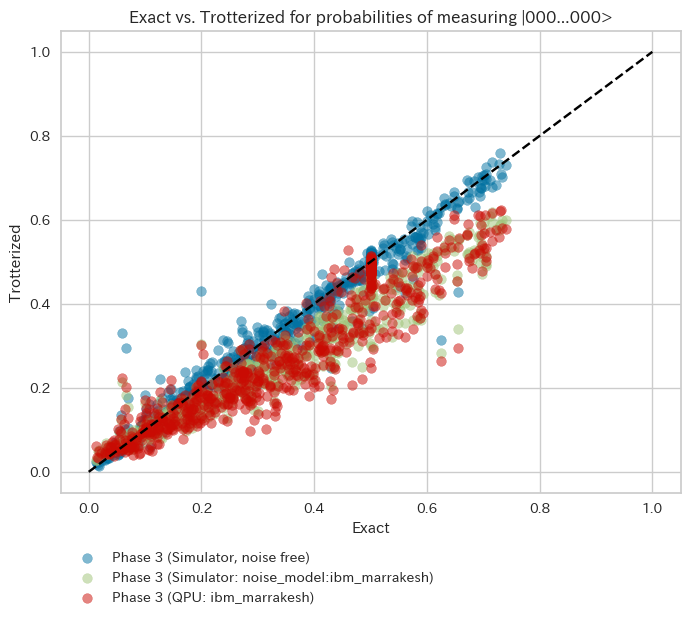

In [16]:
# Plot exact vs. Trotterized results
plt.figure(figsize=(8, 6))
plt.scatter(
    probs_phase3_exact,
    probs_phase3_sim_noiseless,
    label=f"Phase 3 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase3_exact,
    probs_phase3_sim_noisy,
    label=f"Phase 3 (Simulator: noise_model:{backend_qpu_name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase3_exact,
    probs_phase3_qpu,
    label=f"Phase 3 (QPU: {backend_qpu_name})",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

## Regression

In [8]:
# feature_exact_df = pd.read_json(f"{path_exact}/features.json")
feature_sim_noiseless_df = pd.read_json(f"{path_sim_noiseless}/features.json")
# feature_sim_noisy_df = pd.read_json(f"{path_sim_noisy}/features.json")
feature_qpu_df = pd.read_json(f"{path_qpu}/features.json")

### Feature check

In [18]:
print("Exact")
display(feature_exact_df)

Exact


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,...,f_7 Im,f_8 Re,f_8 Im,f_9 Re,f_9 Im,f_10 Re,f_10 Im,f_11 Re,f_11 Im,expected_value
0,0,1,0.884346,-0.290790,0.590681,-0.455664,0.249620,-0.436470,-0.000841,-0.271373,...,0.009273,0.152261,-0.166732,0.070729,-0.392707,-0.143031,-0.553603,-0.408317,-0.568128,0.792109
1,1,1,0.958672,0.058620,0.843443,0.094560,0.675717,0.094943,0.479441,0.058950,...,-0.201326,-0.248002,-0.311919,-0.351952,-0.415939,-0.412986,-0.501580,-0.434392,-0.561235,1.102887
2,2,1,0.969004,0.096452,0.886165,0.168408,0.775616,0.204301,0.661830,0.208788,...,0.159172,0.323352,0.141019,0.262000,0.120255,0.210733,0.096192,0.170814,0.070829,1.130663
3,3,1,0.840284,0.325383,0.476275,0.453387,0.150224,0.358141,0.024002,0.189338,...,0.231905,0.092290,0.220071,0.096749,0.139732,0.156661,0.087465,0.189922,0.117921,1.552866
4,4,1,0.968924,0.122170,0.881160,0.233715,0.750980,0.323699,0.596444,0.381772,...,0.317099,0.023414,0.228696,-0.061265,0.124162,-0.111326,0.015031,-0.126893,-0.089063,1.149036
5,5,1,0.923418,0.235336,0.729782,0.377633,0.508328,0.380620,0.354834,0.267509,...,0.040066,0.576953,0.159808,0.531476,0.315011,0.379545,0.417652,0.182884,0.406051,1.332599
6,6,1,0.877220,0.012721,0.579644,0.070750,0.252072,0.141108,-0.011120,0.139174,...,-0.208172,-0.466443,-0.197567,-0.340189,-0.136247,-0.170852,-0.086931,-0.053671,-0.056556,1.114135
7,7,1,0.919059,-0.036902,0.713936,-0.046552,0.472372,-0.026207,0.276543,0.000777,...,-0.049324,0.016012,-0.063564,-0.046470,-0.039144,-0.103412,0.021718,-0.133714,0.097630,1.034106
8,8,1,0.899118,0.287753,0.650736,0.447320,0.382226,0.426871,0.214108,0.274517,...,-0.010753,0.461227,0.067963,0.462037,0.175611,0.407795,0.272868,0.322557,0.345102,1.421492
9,9,1,0.865913,-0.464001,0.519866,-0.774628,0.095855,-0.855118,-0.270517,-0.728487,...,0.063439,-0.436205,0.269667,-0.250622,0.398224,-0.036802,0.427247,0.153570,0.351521,0.634733


In [19]:
print("Simulator (noise free)")
display(feature_sim_noiseless_df)

Simulator (noise free)


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,...,f_7 Im,f_8 Re,f_8 Im,f_9 Re,f_9 Im,f_10 Re,f_10 Im,f_11 Re,f_11 Im,expected_value
0,0,1,0.876077,-0.277586,0.566648,-0.460112,0.313325,-0.383469,0.044098,-0.233093,...,-0.001500,0.083436,-0.142998,0.027928,-0.354024,-0.099377,-0.475559,-0.290284,-0.508708,0.792109
1,1,1,0.961156,0.060720,0.807814,0.117499,0.643257,0.129190,0.459148,0.117911,...,-0.151477,-0.207359,-0.262626,-0.336024,-0.421669,-0.377320,-0.487814,-0.377292,-0.555319,1.102887
2,2,1,0.977192,0.122331,0.882960,0.177472,0.749348,0.245558,0.599896,0.243739,...,0.190575,0.216572,0.156786,0.262155,0.156681,0.158898,0.117980,0.135672,0.107359,1.130663
3,3,1,0.838372,0.328422,0.498865,0.402542,0.111033,0.282086,0.005683,0.048833,...,0.116560,0.037455,0.035314,0.135668,0.029089,0.241459,0.013092,0.392408,0.074462,1.552866
4,4,1,0.974972,0.113246,0.882893,0.212445,0.732779,0.292554,0.617651,0.346622,...,0.362340,0.140335,0.330283,-0.035514,0.226920,-0.094289,0.114763,-0.138224,0.080617,1.149036
5,5,1,0.910278,0.242566,0.723908,0.402644,0.436203,0.429196,0.198462,0.244871,...,-0.086538,0.589159,-0.035612,0.561372,0.251678,0.459486,0.341311,0.192999,0.390554,1.332599
6,6,1,0.896347,-0.010863,0.547428,-0.016236,0.202588,-0.025103,0.008705,-0.002286,...,-0.262727,-0.300876,-0.276895,-0.352995,-0.061052,-0.224430,0.020474,-0.052865,0.008848,1.114135
7,7,1,0.928492,-0.045633,0.685381,-0.060259,0.405999,-0.039976,0.156939,0.011143,...,-0.019622,-0.034892,-0.038827,-0.055936,-0.044645,-0.087525,-0.047555,-0.143228,0.053737,1.034106
8,8,1,0.893531,0.287058,0.602000,0.446839,0.325641,0.414258,0.072166,0.252510,...,0.006887,0.466211,0.095396,0.477843,0.186231,0.428424,0.281452,0.311454,0.320102,1.421492
9,9,1,0.861970,-0.457988,0.564329,-0.744691,0.074170,-0.864384,-0.298457,-0.684237,...,0.098971,-0.329169,0.262536,-0.237393,0.388007,-0.025972,0.366266,0.154751,0.355877,0.634733


In [20]:
print("Simulator (noisy)")
display(feature_sim_noisy_df)

Simulator (noisy)


NameError: name 'feature_sim_noisy_df' is not defined

## Regression with features from exact (Diagonization)

In [9]:
train_size = 0.8
session_id = 42
sort = "MSE"

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(55, 25)"
4,Transformed data shape,"(55, 24)"
5,Transformed train set shape,"(44, 24)"
6,Transformed test set shape,"(11, 24)"
7,Ignore features,1
8,Numeric features,23
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0130
huber,Huber Regressor,0.0062,0.0004,0.0107,0.9972,0.0046,0.0053,0.0300
ridge,Ridge Regression,0.0371,0.0053,0.0547,0.9630,0.0239,0.0332,0.0130
dt,Decision Tree Regressor,0.0551,0.0059,0.0697,0.9563,0.0300,0.0476,0.0130
gbr,Gradient Boosting Regressor,0.0426,0.0060,0.0569,0.9629,0.0241,0.0356,0.0620
et,Extra Trees Regressor,0.0380,0.0068,0.0552,0.9603,0.0230,0.0308,0.1670
par,Passive Aggressive Regressor,0.0618,0.0087,0.0792,0.9423,0.0326,0.0519,0.0130
rf,Random Forest Regressor,0.0532,0.0087,0.0720,0.9474,0.0311,0.0460,0.2460
ada,AdaBoost Regressor,0.0587,0.0102,0.0796,0.9377,0.0339,0.0487,0.0650
knn,K Neighbors Regressor,0.0789,0.0152,0.1036,0.9016,0.0467,0.0751,0.0360


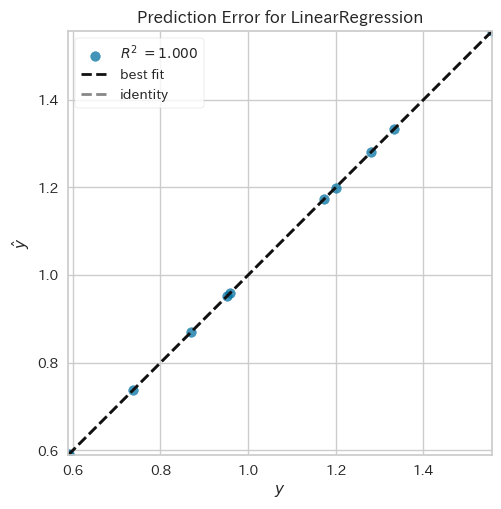

In [19]:
s_exact = RegressionExperiment()
s_exact.setup(
    data=feature_exact_df,
    target="expected_value",
    ignore_features=["sample_id"],
    train_size=train_size,
    session_id=session_id,
    use_gpu=True,  # Use GPU
)

best_exact = s_exact.compare_models(turbo=True, sort=sort)
s_exact.plot_model(best_exact, plot="error")

## Regression with features from noiseless simulation

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0


[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Wa

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.


,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(55, 25)"
4,Transformed data shape,"(55, 24)"
5,Transformed train set shape,"(44, 24)"
6,Transformed test set shape,"(11, 24)"
7,Ignore features,1
8,Numeric features,23
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.0139,0.0023,0.0228,0.9679,0.0103,0.0117,0.0130
lr,Linear Regression,0.0170,0.0031,0.0273,0.9554,0.0124,0.0145,0.0130
huber,Huber Regressor,0.0179,0.0039,0.0295,0.9476,0.0134,0.0150,0.0300
ridge,Ridge Regression,0.0200,0.0060,0.0353,0.9190,0.0162,0.0165,0.0120
ada,AdaBoost Regressor,0.0262,0.0063,0.0429,0.8926,0.0197,0.0221,0.0640
omp,Orthogonal Matching Pursuit,0.0319,0.0070,0.0495,0.8719,0.0244,0.0303,0.0120
rf,Random Forest Regressor,0.0244,0.0072,0.0439,0.8891,0.0205,0.0208,0.2530
et,Extra Trees Regressor,0.0191,0.0072,0.0344,0.9138,0.0156,0.0147,0.1750
knn,K Neighbors Regressor,0.0336,0.0074,0.0549,0.8470,0.0262,0.0308,0.0660
gbr,Gradient Boosting Regressor,0.0228,0.0076,0.0393,0.9024,0.0178,0.0178,0.0610


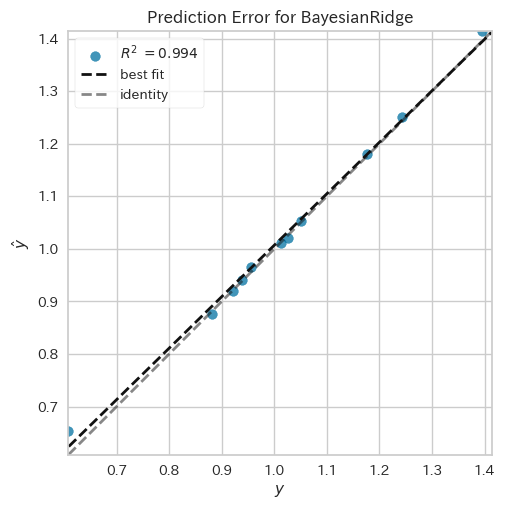

In [10]:
s_sim_noiseless = RegressionExperiment()
s_sim_noiseless.setup(
    data=feature_sim_noiseless_df,
    target="expected_value",
    ignore_features=["sample_id"],
    train_size=train_size,
    session_id=session_id,
    use_gpu=True,  # only for GPU
)

best_sim_noiseless = s_sim_noiseless.compare_models(turbo=True, sort=sort)
s_sim_noiseless.plot_model(best_sim_noiseless, plot="error")

## Regression with features from noisy simulation

In [11]:
def create_model_and_plot(
    experiment: RegressionExperiment,
    exact_experiment: RegressionExperiment = None,  # 比較用: 厳密対角化の結果
    sim_noiseless_experiment: RegressionExperiment = None,  # 比較用: MPS シミュレータのノイズなしの結果
    reg_method=None,  # 回帰手法. "ada", "dt", "et", "gbr", "knn", "lar", "lightgbm", "lr", "mlp", "omp", "par", "ransac", "rf", "ridge", "svm", "xgboost"
    is_qpu=False,  # QPU の結果かどうか
) -> None:
    # モデルを作成
    if reg_method:  # 指定された回帰手法でモデルを作成
        model = experiment.create_model(reg_method, verbose=False)
        sim_model = sim_noiseless_experiment.create_model(reg_method, verbose=False)
    else:  # 指定されなければ最適なモデルを作成
        model = experiment.compare_models(turbo=True, sort=sort, verbose=False)
        sim_model = sim_noiseless_experiment.compare_models(
            turbo=True, sort=sort, verbose=False
        )

    if exact_experiment is not None:  # 12 qubits 以下の場合のみ実行
        # exact は最適なモデル (おそらく線形回帰) を作成
        exact_model = exact_experiment.compare_models(
            turbo=True, sort=sort, verbose=False
        )
        exact_experiment.tune_model(
            exact_model, optimize=sort, choose_better=True, verbose=False
        )

    experiment.tune_model(model, optimize=sort, choose_better=True, verbose=False)

    # 回帰手法の名前を取得
    reg_method = model.__class__.__name__
    sim_reg_method = sim_model.__class__.__name__
    if exact_experiment is not None:  # 12 qubits 以下の場合のみ実行
        exact_reg_method = exact_model.__class__.__name__

    # 予測
    pred = experiment.predict_model(model)
    x = pred["expected_value"].values.reshape(-1, 1)  # サンプル数 x 1
    y = pred["prediction_label"].values
    r2 = r2_score(x, y)
    mse = mean_squared_error(x, y)

    sim_pred = sim_noiseless_experiment.predict_model(sim_model)
    sim_x = sim_pred["expected_value"].values.reshape(-1, 1)
    sim_y = sim_pred["prediction_label"].values
    sim_r2 = r2_score(sim_x, sim_y)
    sim_mse = mean_squared_error(sim_x, sim_y)

    if exact_experiment is not None:  # 12 qubits 以下の場合のみ実行
        exact_pred = exact_experiment.predict_model(exact_model)
        exact_x = exact_pred["expected_value"].values.reshape(-1, 1)
        exact_y = exact_pred["prediction_label"].values
        exact_r2 = r2_score(exact_x, exact_y)
        exact_mse = mean_squared_error(exact_x, exact_y)

    # 回帰直線を計算
    linear_model = LinearRegression()
    linear_model.fit(x, y)
    slope = linear_model.coef_[0]
    intercept = linear_model.intercept_

    sim_linear_model = LinearRegression()
    sim_linear_model.fit(sim_x, sim_y)
    sim_slope = sim_linear_model.coef_[0]
    sim_intercept = sim_linear_model.intercept_

    if exact_experiment is not None:  # 12 qubits 以下の場合のみ実行
        exact_linear_model = LinearRegression()
        exact_linear_model.fit(exact_x, exact_y)
        exact_slope = exact_linear_model.coef_[0]
        exact_intercept = exact_linear_model.intercept_

    # プロット
    device = "QPU" if is_qpu else "Sim"
    plt.figure(figsize=(8, 6))
    plt.scatter(
        x,
        y,
        alpha=0.5,
        color="green",
        label=f"{device}: {reg_method}, R2 = {r2:.2e}, MSE = {mse:.2e}",
    )
    plt.scatter(
        sim_x,
        sim_y,
        alpha=0.5,
        color="blue",
        label=f"MPS Sim (noise free): {sim_reg_method}, R2 = {sim_r2:.2e}, MSE = {sim_mse:.2e}",
    )
    if exact_experiment is not None:  # 12 qubits 以下の場合のみ実行
        plt.scatter(
            exact_x,
            exact_y,
            alpha=0.5,
            color="red",
            label=f"Diag: {exact_reg_method}, R2 = {exact_r2:.2e}, MSE = {exact_mse:.2e}",
        )

    # 回帰直線を追加
    x_range = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    plt.plot(
        x_range,
        linear_model.predict(x_range),
        color="green",
        label=f"{device}: Best fit line (y = {slope:.2e}x {'+' if intercept >= 0 else '-'} {abs(intercept):.2e})",
    )
    sim_x_range = np.linspace(sim_x.min(), sim_x.max(), 100).reshape(-1, 1)
    plt.plot(
        sim_x_range,
        sim_linear_model.predict(sim_x_range),
        color="blue",
        label=f"MPS Sim (noise free): Best fit line (y = {sim_slope:.2e}x {'+' if sim_intercept >= 0 else '-'} {abs(sim_intercept):.2e})",
    )
    if exact_experiment is not None:  # 12 qubits 以下の場合のみ実行
        exact_x_range = np.linspace(exact_x.min(), exact_x.max(), 100).reshape(-1, 1)
        plt.plot(
            exact_x_range,
            exact_linear_model.predict(exact_x_range),
            color="red",
            label=f"Diag: Best fit line (y = {exact_slope:.2e}x {'+' if exact_intercept >= 0 else '-'} {abs(exact_intercept):.2e})",
        )

    # Identity line
    plt.plot(
        [x.min(), x.max()], [x.min(), x.max()], "--", color="black", label="Identity"
    )

    # plt.rcParams["font.size"] = 16  # Docker だと反応しない？
    plt.tick_params(labelsize=12)
    plt.xlabel("Actual", fontsize=14)
    plt.ylabel("Predicted", fontsize=14)
    plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left", fontsize=14)
    plt.title(f"{n_qubits} qubits", fontsize=16)

    if is_qpu:
        plt.savefig(
            f"results/regression/{n_qubits}Q/regression_qpu.pdf",
            bbox_inches="tight",
        )
    else:
        plt.savefig(
            f"results/regression/{n_qubits}Q/regression_noisy_sim.pdf",
            bbox_inches="tight",
        )
    plt.show()

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(55, 25)"
4,Transformed data shape,"(55, 24)"
5,Transformed train set shape,"(44, 24)"
6,Transformed test set shape,"(11, 24)"
7,Ignore features,1
8,Numeric features,23
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.0160,0.0003,0.0183,0.9963,0.0091,0.0163


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.0252,0.0009,0.0296,0.9902,0.0165,0.0304


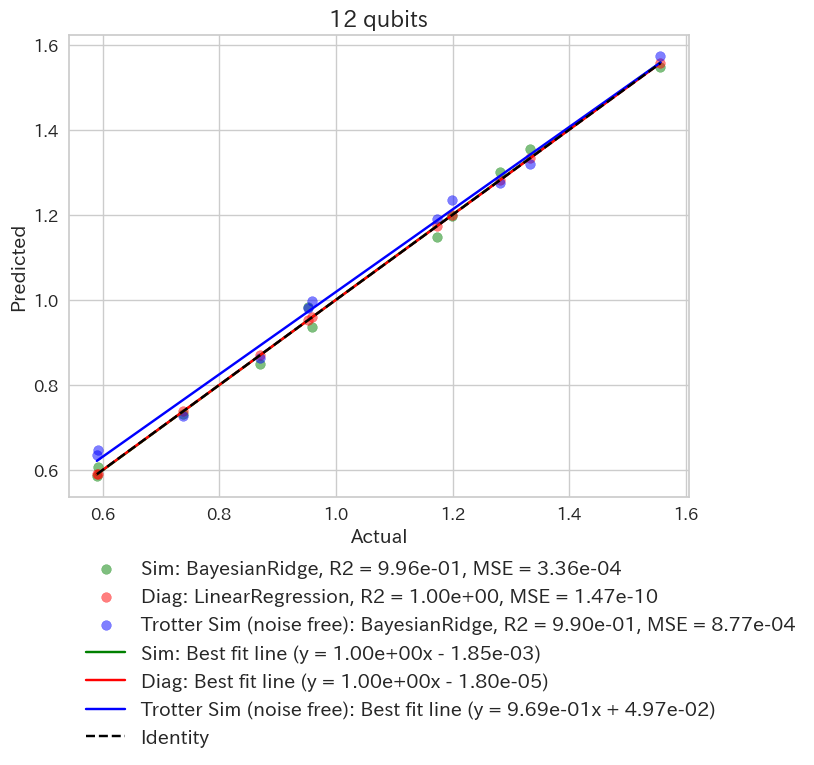

In [24]:
s_sim_noisy = RegressionExperiment()
s_sim_noisy.setup(
    data=feature_sim_noisy_df,
    target="expected_value",
    ignore_features=["sample_id"],
    train_size=train_size,
    session_id=session_id,
    use_gpu=True,  # only for GPU
)
create_model_and_plot(s_sim_noisy, s_exact, s_sim_noiseless, is_qpu=False)

In [25]:
# これと同じ予測を上のセルでは行なっている
# best_sim_noisy = s_sim_noisy.compare_models(turbo=True, sort=sort)
# s_sim_noisy.plot_model(best_sim_noisy, plot="error")

## Regression with features from QPU

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(55, 25)"
4,Transformed data shape,"(55, 24)"
5,Transformed train set shape,"(44, 24)"
6,Transformed test set shape,"(11, 24)"
7,Ignore features,1
8,Numeric features,23
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1454,0.0553,0.2352,-0.4296,0.1185,0.1699


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.0093,0.0002,0.0152,0.9940,0.0088,0.0114


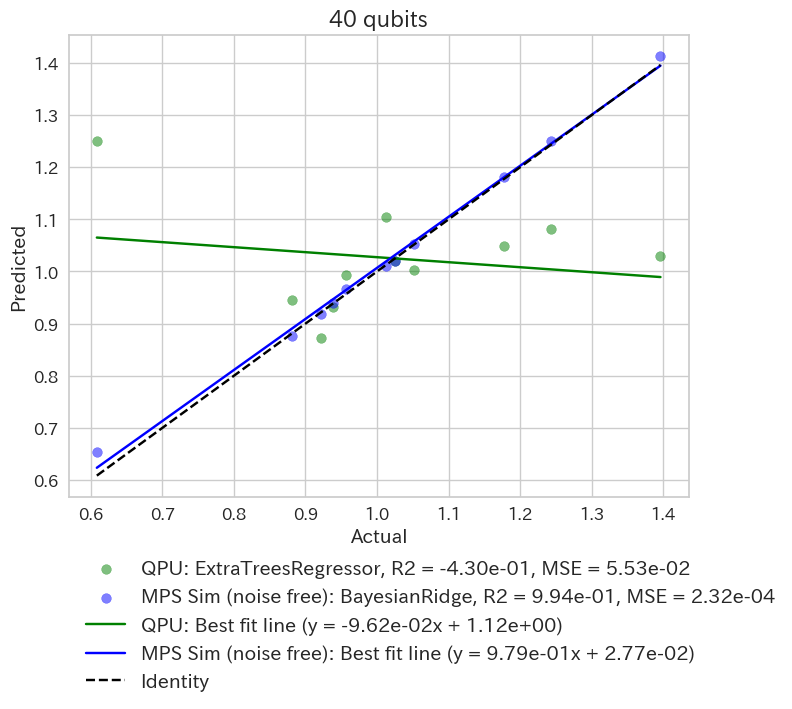

In [13]:
s_qpu = RegressionExperiment()
s_qpu.setup(
    data=feature_qpu_df,
    target="expected_value",
    ignore_features=["sample_id"],
    train_size=train_size,
    session_id=session_id,
    use_gpu=True,  # only for GPU
)
# 12 qubits 以下の場合のみ実行
# create_model_and_plot(s_qpu, s_exact, s_sim_noiseless, is_qpu=True)

# 12 qubits 以上の場合のみ実行
create_model_and_plot(
    s_qpu, exact_experiment=None, sim_noiseless_experiment=s_sim_noiseless, is_qpu=True
)

In [35]:
# これと同じ予測を上のセルでは行なっている
# best_nmit = s_nmit.compare_models(turbo=True, sort=sort)
# s_nmit.plot_model(best_nmit, plot="error")